<a href="https://colab.research.google.com/github/project-mlx/Stats/blob/main/stats_5_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ARIMA performed on a shamoo sales dataset 
(The original dataset is credited to Makridakis, Wheelwright, and Hyndman (1998))

- Stats analysis
- Model fitting
- Evaluation
- Accuray assessment


In [119]:
import pandas as pd
from matplotlib import pyplot

In [120]:
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv')

In [121]:
df.head()

,Month,Sales
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3


##Preprocessing

In [122]:
#implementing custom dates as they are not available in the dataset
df.Month = df.Month.apply(lambda x: pd.datetime.strptime('190'+x, '%Y-%m'))
df = df.set_index('Month')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


In [123]:
df.head()

,Sales
Month,
1901-01-01,266.0
1901-02-01,145.9
1901-03-01,183.1
1901-04-01,119.3
1901-05-01,180.3


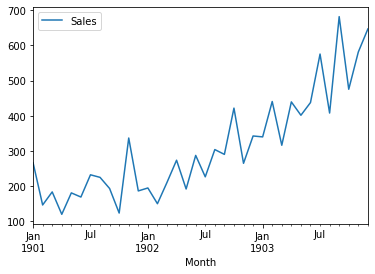

In [124]:
df.plot()

The shampoo sales shows a clear trend
##Determining the right lag for ARIMA
We can decide it by looking the at the correlation betweeen subsequent time periods.

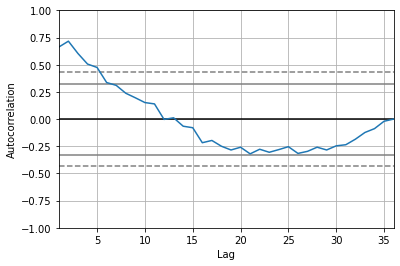

In [125]:
pd.plotting.autocorrelation_plot(df)
pyplot.show()

There is a strong correlation in the first 5 lags, therofore, we can consider 5 as the P value and since the data is not stationary (the trends in the dataset), as seen in the df, we can set 1 as the d value for a minor diffrencing for making it stationary.

##Modelling and Evaluation

In [126]:
from statsmodels.tsa.arima_model import ARIMA

In [127]:
df.index = df.index.to_period('M')

In [128]:
df.head()

,Sales
Month,
1901-01,266.0
1901-02,145.9
1901-03,183.1
1901-04,119.3
1901-05,180.3


Data Split

In [129]:
train_size = int(df.shape[0]*0.7)

In [130]:
train, test = df.iloc[0:train_size], df.iloc[train_size:df.shape[0]]

In [131]:
model = ARIMA(train, order=(5,1,0))
model_fit = model.fit()

Model evaluation

In [132]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                   24
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -131.525
Method:                       css-mle   S.D. of innovations             56.043
Date:                Mon, 08 Feb 2021   AIC                            277.051
Time:                        14:44:26   BIC                            285.297
Sample:                    02-28-1901   HQIC                           279.238
                         - 01-31-1903                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             7.4115      3.240      2.288      0.034       1.062      13.761
ar.L1.D.Sales    -1.0402      0.225     -4.614      0.000      -1.482      -0.598
ar.L2.D.Sales    -0.7527      0.327     

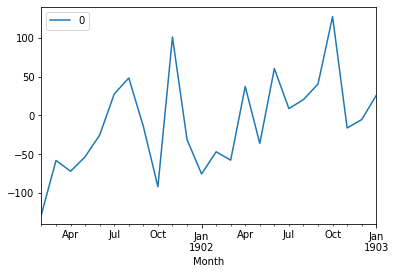

In [133]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()

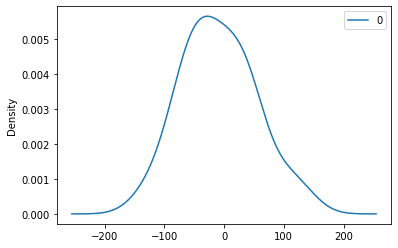

In [134]:
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()

The residual is following a normal distribution however its not zero, to be tter understand, we will describe the residuals.

In [135]:
# stats of residuals
residuals.describe()

,0
count,24.000000
mean,-8.956821
std,61.193480
min,-127.511480
25%,-54.439924
50%,-15.216597
75%,29.940979
max,127.229760


Since the model consider the past values as the input for the predictions, we will follow a rolling window strategy for predictions and re-fitting the model on every iteration.

##Forecast and Accuracy Measure

In [141]:
from sklearn.metrics import mean_absolute_error

In [142]:
past_data = [i[0] for i in train.values]
n_test = [i[0] for i in test.values]

predicted = [387.37641812], expected = 440.4
predicted = [348.15413193], expected = 315.9
predicted = [386.30878001], expected = 439.3
predicted = [356.08203151], expected = 401.3
predicted = [446.37950029], expected = 437.4
predicted = [394.7372418], expected = 575.5
predicted = [434.91552364], expected = 407.6
predicted = [507.92341154], expected = 682.0
predicted = [435.48287297], expected = 475.3
predicted = [652.74376206], expected = 581.3
predicted = [546.34351034], expected = 646.9
Test MAE: 90.106


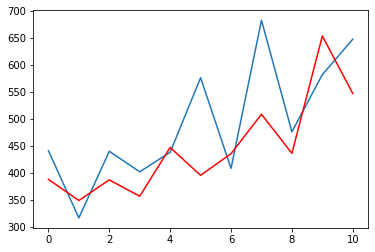

In [143]:
predictions = []
# walk-forward validation
for t in range(len(n_test)):
	model = ARIMA(past_data, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	y_predict = output[0]
	predictions.append(y_predict)
	obs = n_test[t]
	past_data.append(obs)
	print('predicted = {}, expected = {}'.format(y_predict, obs))
# evaluate forecasts
mae = mean_absolute_error(n_test, predictions)
print('Test MAE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(n_test)
pyplot.plot(predictions, color='red')
pyplot.show()

The predictions are alright, considering, we didn't do any tuning. the p, d, q parameters can be tuned to improve the accuracy.